<img src="grizli_logo.png">

# Basic Grizli tutorial 

What we'll be going over in this tutorial:

1) Selecting a field to extract data from

2) Automatically reducing data using Grizli's auto_script.go feature

3) Extracting data and overview of data products

4) How to interact with data

This tutorial is based upon the <a href="https://github.com/gbrammer/grizli/blob/master/examples/Grizli-Pipeline.ipynb">Grizli-Pipeline</a> demo which includes a more indepth breakdown of the reduction process. 


The easiest way to install Grizli is to use the grizli-dev python environment (which should install all dependices), instructions for installation are included <a href="https://grizli.readthedocs.io/en/master/">here</a>. 

In [1]:
import glob
import time
import os
import sys
import yaml

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

import astropy.io.fits as pyfits
import drizzlepac

import warnings
warnings.filterwarnings('ignore')

from mastquery import query, overlaps

import grizli
from grizli.pipeline import auto_script
from grizli import utils, fitting, multifit, prep
HOME_PATH = os.getcwd()




The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


## Step 1 - Select a field and run an archive query with mastquery


# (Mon Apr 26 10:46:50 2021)

query.run_query(**{'kwargs': {'proposal_id': [], 'instruments': ['WFC3/IR', 'ACS/WFC'], 'filters': ['F105W', 'G102', 'G141']}, 'base_query': {'intentType': ['science'], 'mtFlag': ['False'], 'obs_collection': ['HST'], 't_exptime': [1, 1000000.0], 'project': ['HST']}, 'position_box': True, 'sort_column': ['obs_id', 'filter'], 'rename_columns': {'t_exptime': 'exptime', 'target_name': 'target', 's_region': 'footprint', 's_ra': 'ra', 's_dec': 'dec', 'filters': 'filter'}, 'get_exptime': True, 'box': [53.15796, -27.7282, 1.5]})


Parse polygons
Parse    1 (N=1)
Parse    2 (N=2)
Parse    3 (N=2)
Parse    4 (N=2)
Parse    5 (N=2)
Parse    6 (N=2)
Parse    7 (N=2)
Parse    8 (N=2)
Parse    9 (N=2)
Parse   10 (N=2)
Parse   11 (N=2)
Parse   12 (N=2)
Parse   13 (N=2)
Parse   14 (N=2)
Parse   15 (N=2)
Parse, iter 1,    1
Iter #1, N_Patch = 1
Iter #2, N_Patch = 1


 1 j033236m2744 53.15820836642586 -27.7343775186869

# (Mon Apr 26 10:46:51 2021)

query.run_query(**{'kwa

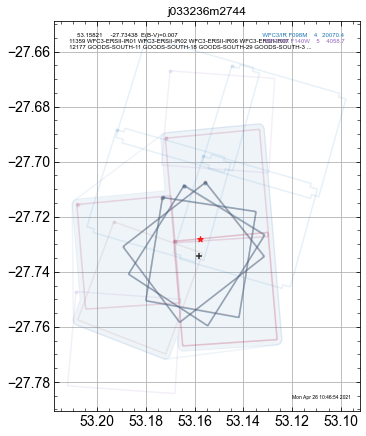

In [12]:
## First we need to define a few parameters for the query
base_query= {'intentType': ['science'], 'mtFlag': ['False'], 'obs_collection': ['HST'], 't_exptime':[1,1E6], 'project':['HST']}

## Second we will run an archive query, this can be done either using a proposal id (left blank here) or by defining a box to 
## search over (here we'll be using one of the CLEAR fields). We also need to tell mastquery which instruments we want to query
## and which filters. 
parent = query.run_query(box=[53.15796,-27.72820, 1.5], proposal_id=[],
                         instruments=['WFC3/IR', 'ACS/WFC'],
                         filters=['F105W','G102', 'G141'], base_query=base_query)

## Third we will look for overlaps. Here we can include additional filters which overlap with our current filters + the buffer_arcmin.
tabs = overlaps.find_overlaps(parent,  buffer_arcmin=0.1,
                              filters=['F098M','F140W'], 
                              close=False, base_query=base_query)


## Step 2 - Reduce the data

In [23]:
from grizli.pipeline.auto_script import get_yml_parameters

## Read the default parameters that can be edited and passed en-masse to `auto_script.go`
kwargs = get_yml_parameters()
print(list(kwargs.keys()))

root = 'j033240m2744'

############# need to check
kwargs['fetch_files_args']['reprocess_clean_darks'] = False 
kwargs['fetch_files_args']['reprocess_parallel'] = True

## Set to True for parallel programs like WISPS
IS_PARALLEL = False
kwargs['is_parallel_field'] = IS_PARALLEL

['filters', 'fetch_files_args', 'inspect_ramps', 'is_dash', 'run_prepare_dash', 'run_parse_visits', 'is_parallel_field', 'parse_visits_args', 'manual_alignment', 'manual_alignment_args', 'preprocess_args', 'visit_prep_args', 'redo_persistence_mask', 'persistence_args', 'run_fine_alignment', 'fine_backup', 'fine_alignment_args', 'make_mosaics', 'mosaic_args', 'mosaic_drizzle_args', 'mask_spikes', 'mosaic_driz_cr_type', 'make_phot', 'multiband_catalog_args', 'only_preprocess', 'overwrite_fit_params', 'grism_prep_args', 'refine_with_fits', 'run_extractions', 'include_photometry_in_fit', 'make_thumbnails', 'thumb_rgb_params', 'drizzler_args', 'thumbnail_args', 'extract_args', 'extract_maglim', 'run_fit']


The next step is to run auto_script.go, this will fetch the data from the HST archive, parse visit associations, align images, sky subtraction, fin alignment using GAIA DR2, generate a photometric catalog, and model the contamination iterativly. 

In [ ]:
## The next step is to run auto_script.go, this will fetch the data from 
## the HST archive, parse visit associations, align images, sky subtraction, 
## fine alignment using GAIA DR2, generate a photometric catalog, and model the contamination iterativly. 


## auto_script.go can take a while (this field takes around an hour on my computer), therefore
## we won't be running it today, rather I have provided the *GrismFLT.fits files. 
if False:
    auto_script.go(root=root, HOME_PATH=HOME_PATH, **kwargs)

In [7]:
# PREP_PATH = '{}/{}/Prep/'.format(HOME_PATH, root)
EXTRACT_PATH = '{}/{}/Extractions/'.format(HOME_PATH, root)

## Step 3 - Extracting spectra

We can skip straight to extracting data with only the *GrismFLT.fits files and the *ir.cat.fits catalog using the multifit.GroupFLT function.

In [8]:
grp = multifit.GroupFLT(grism_files=glob.glob(EXTRACT_PATH + '*GrismFLT.fits'), 
                            catalog=EXTRACT_PATH + '{}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)

Load /Users/Vince.ec/GitHub/grizli_example/j033240m2744/Extractions/ibhj33u3q.01.GrismFLT.fits!
Load /Users/Vince.ec/GitHub/grizli_example/j033240m2744/Extractions/icxt34emq.01.GrismFLT.fits!
Load /Users/Vince.ec/GitHub/grizli_example/j033240m2744/Extractions/icxt35s9q.01.GrismFLT.fits!
Load /Users/Vince.ec/GitHub/grizli_example/j033240m2744/Extractions/icxt31r1q.01.GrismFLT.fits!
Load /Users/Vince.ec/GitHub/grizli_example/j033240m2744/Extractions/ibhj29ncq.01.GrismFLT.fits!
Load /Users/Vince.ec/GitHub/grizli_example/j033240m2744/Extractions/icxt34erq.01.GrismFLT.fits!
Load /Users/Vince.ec/GitHub/grizli_example/j033240m2744/Extractions/icxt32npq.01.GrismFLT.fits!
Load /Users/Vince.ec/GitHub/grizli_example/j033240m2744/Extractions/icxt33rsq.01.GrismFLT.fits!
Load /Users/Vince.ec/GitHub/grizli_example/j033240m2744/Extractions/ibhj11hpq.01.GrismFLT.fits!
Load /Users/Vince.ec/GitHub/grizli_example/j033240m2744/Extractions/icxt32nmq.01.GrismFLT.fits!
Load /Users/Vince.ec/GitHub/grizli_examp

Contamination modeling, through an iterative process Grizli models continua of sources.

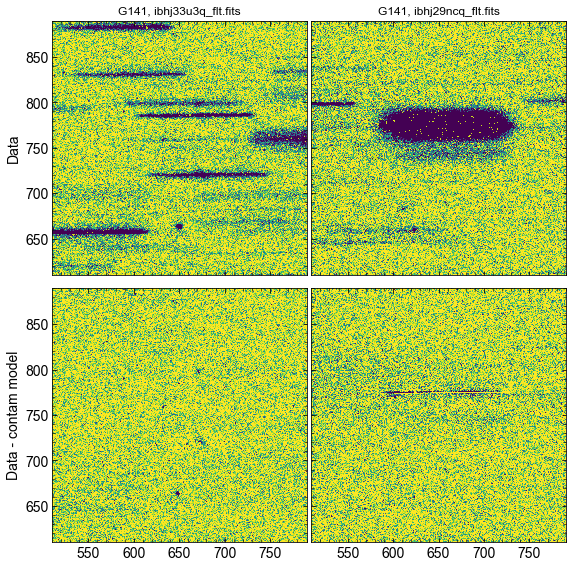

In [9]:
# Show the results of the contamination model
### Show FLT residuals
cmap = 'viridis_r'
vm = [-0.01, 0.1]

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(221)
flt = grp.FLTs[0] # G102

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([])
ax.set_ylabel('Data')

ax = fig.add_subplot(223)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_ylabel('Data - contam model')

ax = fig.add_subplot(222)
flt = grp.FLTs[4] # G141

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([]); ax.set_yticklabels([])

ax = fig.add_subplot(224)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_yticklabels([])

for ax in fig.axes:
    ax.set_xlim(510,790); ax.set_ylim(610,890)

fig.tight_layout(pad=1)

In [10]:
## Store fit parameters to `fit_args.npy` for batch-mode processing
os.chdir(EXTRACT_PATH)

## Drizzle parameters for line maps
pline = auto_script.DITHERED_PLINE

## Generate the parameter dictionary
args = auto_script.generate_fit_params(field_root=root, prior=None, 
                                       MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                                fsps=True, sys_err = 0.03, fcontam=0.2, zr=[0.05, 3.4], 
                                save_file='fit_args.npy')

{'kernel': 'point', 'pixfrac': 0.2, 'pixscale': 0.1, 'size': 8, 'wcs': None}
Apply catalog corrections
Read default param file: /Users/Vince.ec/miniconda3/envs/astroconda3.6/lib/python3.6/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: j033240m2744_phot_apcorr.fits
f105w_tot_0 f105w_etot_0 (202): hst/wfc3/IR/f105w.dat
f140w_tot_0 f140w_etot_0 (204): hst/wfc3/IR/f140w.dat
Read PRIOR_FILE:  templates/prior_F160W_TAO.dat
Process template tweak_fsps_QSF_12_v3_001.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_002.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_003.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_004.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_005.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_006.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_007.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_008.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_009.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_010.dat (NZ=1).
Process template tweak_

In [11]:
## Find IDs of specific objects to extract using ra and dec
import astropy.units as u
tab = utils.GTable()
tab['ra'] = [53.15273]
tab['dec'] = [-27.71625]
idx, dr = grp.catalog.match_to_catalog_sky(tab)
print(grp.catalog['NUMBER'][idx])

source_id = grp.catalog['NUMBER'][idx][0]
tab['id'] = source_id
tab['dr'] = dr.to(u.mas)
tab['dr'].format='.1f'
tab.show_in_notebook()

NUMBER
------
  1490


In [12]:
## Extract beams
auto_script.extract(field_root=root, ids=[source_id], MW_EBV=tabs[0].meta['MW_EBV'], 
                run_fit=False, grp=grp, diff=True)

0/1: 1490 28


INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizz

j033240m2744_01490.beams.fits


True

Run id=1490 with fit_args.npy


INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizz

j033240m2744_01490.full.fits


INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizz

(1490, 1, 167.21262907981873)

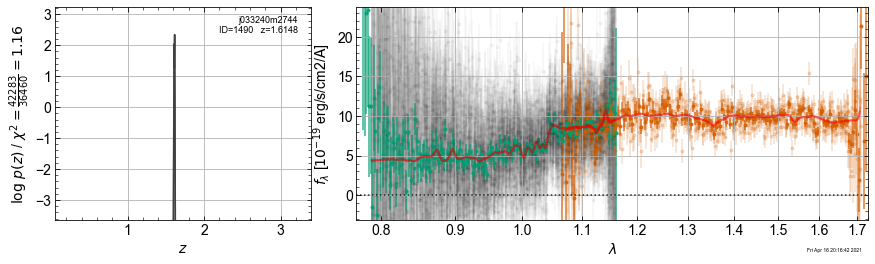

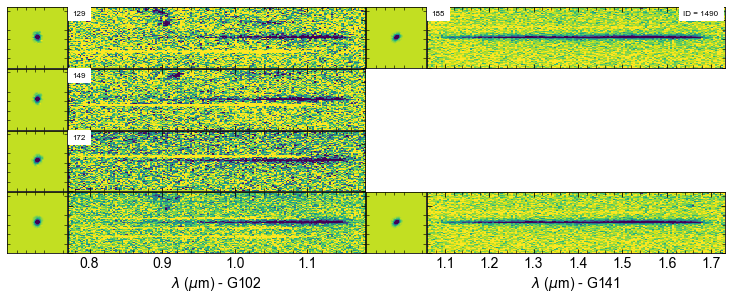

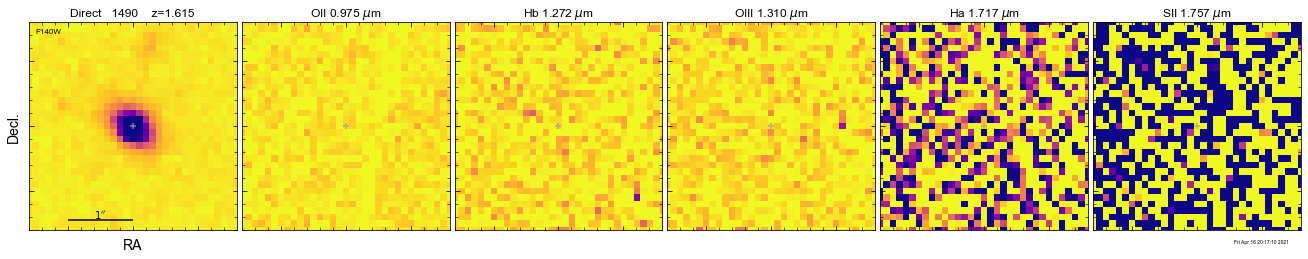

In [14]:
## fit the galaxy using a set of templates to fit redshift and the stellar populations, in addition to 
## generating line maps (though this has no emission lines)
fitting.run_all_parallel(source_id)

In [16]:
## Now we'll extract a star-forming galaxy
source_id = 546
auto_script.extract(field_root=root, ids=[source_id], MW_EBV=tabs[0].meta['MW_EBV'], 
                run_fit=False, grp=grp, diff=True)

0/1: 546 28


INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizz

j033240m2744_00546.beams.fits


True

Run id=546 with fit_args.npy


INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizz

j033240m2744_00546.full.fits


INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizz

(546, 1, 193.37870407104492)

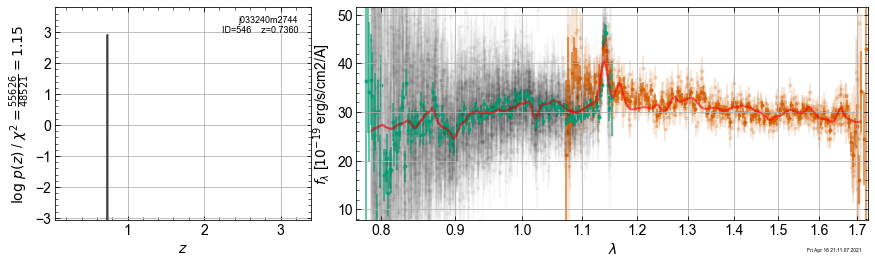

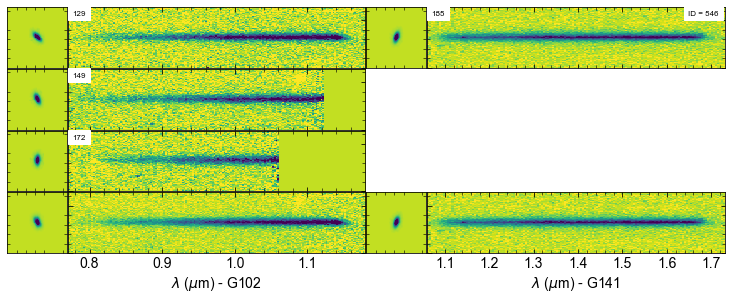

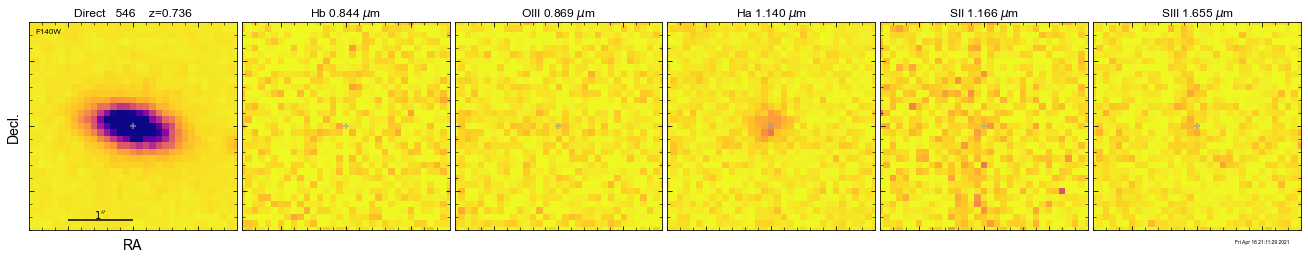

In [17]:
fitting.run_all_parallel(source_id)

In [19]:
## heres a galaxy with multiple emission lines
source_id = 1389
auto_script.extract(field_root=root, ids=[source_id], MW_EBV=tabs[0].meta['MW_EBV'], 
                run_fit=False, grp=grp, diff=True)

0/1: 1389 28


INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizz

j033240m2744_01389.beams.fits


True

Run id=1389 with fit_args.npy


INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizz

j033240m2744_01389.full.fits


INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizzlepac.cdriz:-Drizzling using kernel = point

INFO:drizz

(1389, 1, 159.19773626327515)

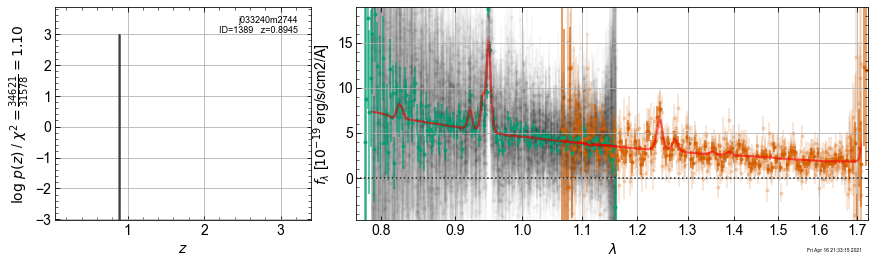

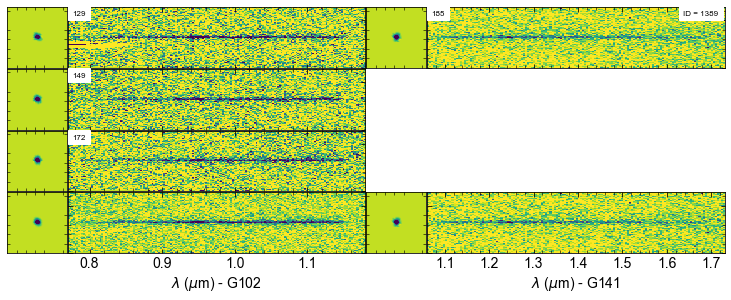

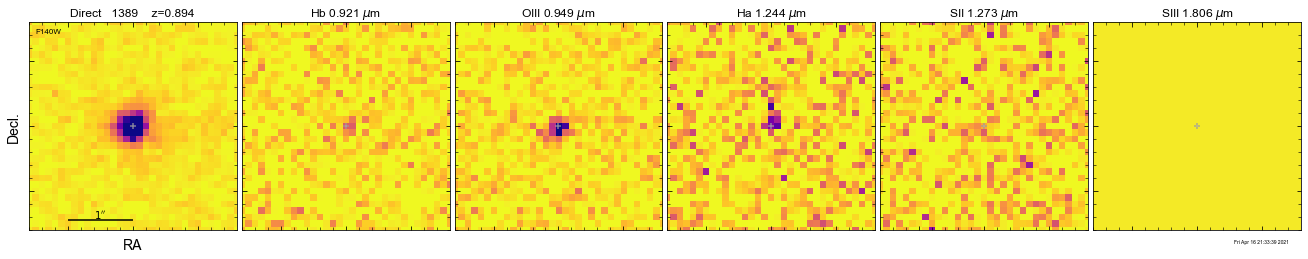

In [20]:
fitting.run_all_parallel(source_id)

## Step 4 - Interacting with the data

In [15]:
from grizli import multifit

In [23]:
## multifit.MultiBeam reads in the *beams.fits files and allows you interact with the data.
## *beams.fits files contain cutouts of the beams along with the contamination

os.chdir(EXTRACT_PATH)
mb = multifit.MultiBeam('j033240m2744_01490.beams.fits')

load_master_fits: j033240m2744_01490.beams.fits
1 icxt34emq_flt.fits G102
2 icxt35s9q_flt.fits G102
3 icxt31r1q_flt.fits G102
4 icxt34erq_flt.fits G102
5 icxt32npq_flt.fits G102
6 icxt33rsq_flt.fits G102
7 ibhj11hpq_flt.fits G141
8 icxt32nmq_flt.fits G102
9 icxt33ruq_flt.fits G102
10 icxt31r6q_flt.fits G102
11 icxt33rpq_flt.fits G102
12 icxt31r3q_flt.fits G102
13 icxt34epq_flt.fits G102
14 icxt32nlq_flt.fits G102
15 ibhj11hiq_flt.fits G141
16 icxt32nrq_flt.fits G102
17 ibhj11hwq_flt.fits G141
18 icxt35sbq_flt.fits G102
19 icxt33roq_flt.fits G102
20 icxt34ekq_flt.fits G102
21 icxt35s6q_flt.fits G102
22 icxt30s7q_flt.fits G102
23 icxt30s2q_flt.fits G102
24 icxt35s4q_flt.fits G102
25 ibhj11i3q_flt.fits G141
26 icxt30s5q_flt.fits G102
27 icxt30s0q_flt.fits G102
28 icxt31r8q_flt.fits G102


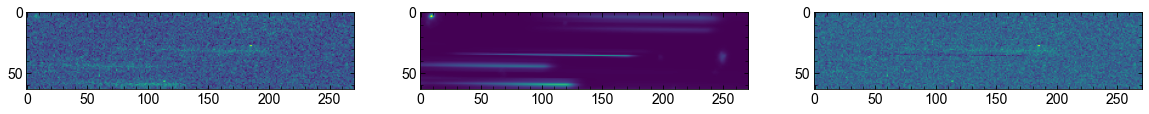

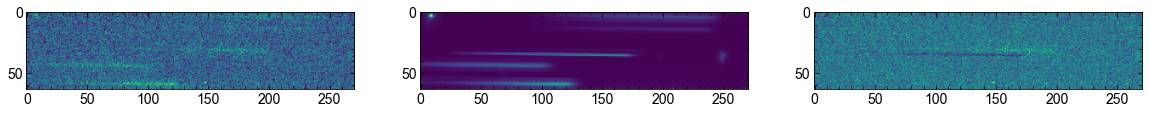

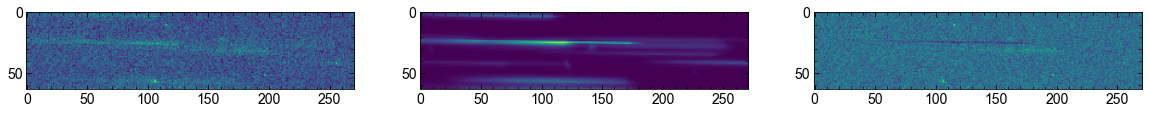

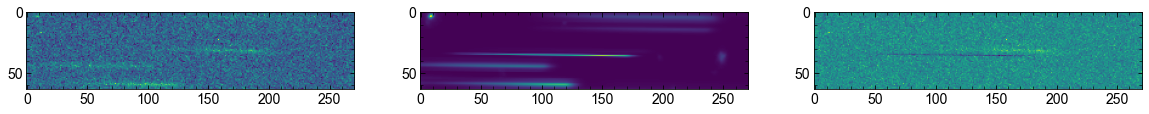

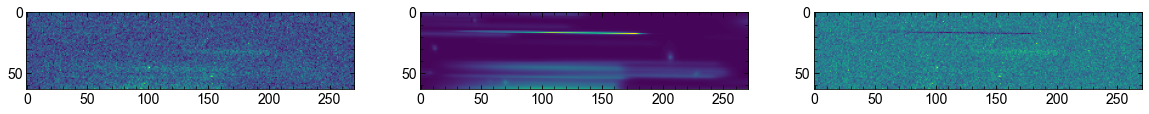

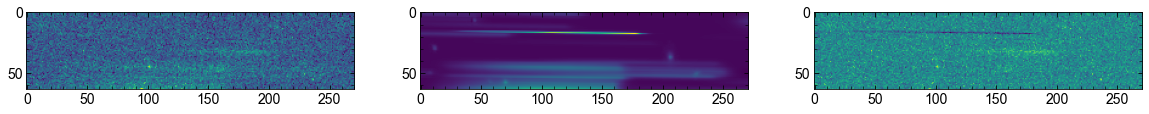

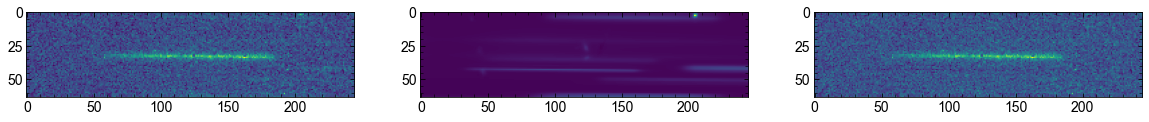

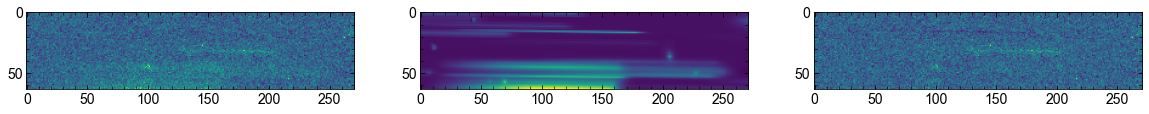

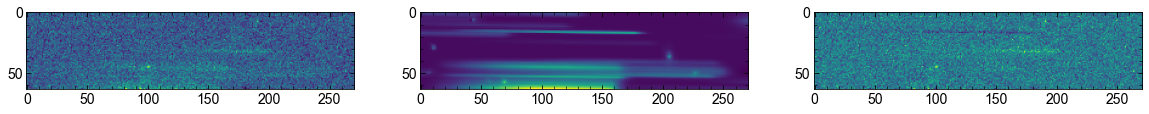

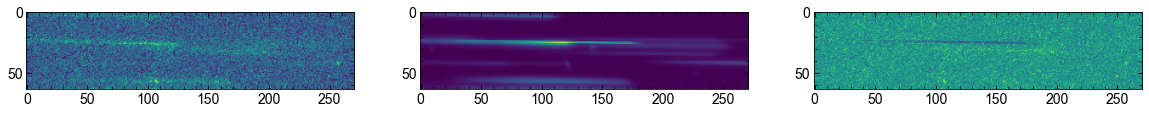

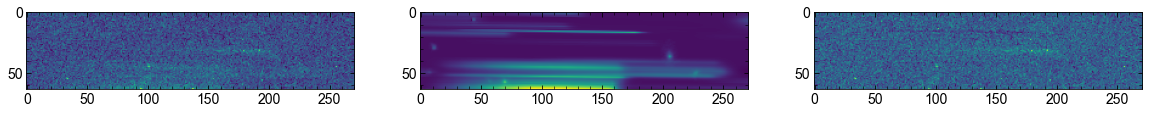

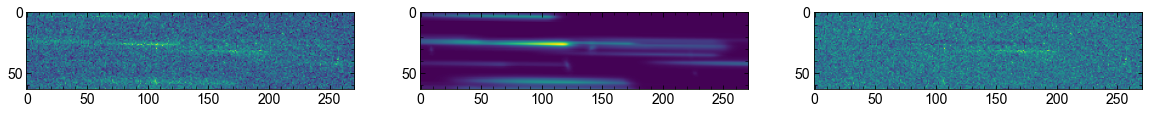

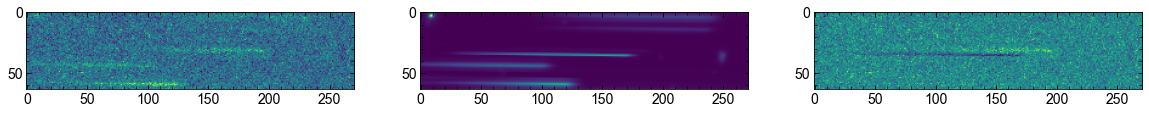

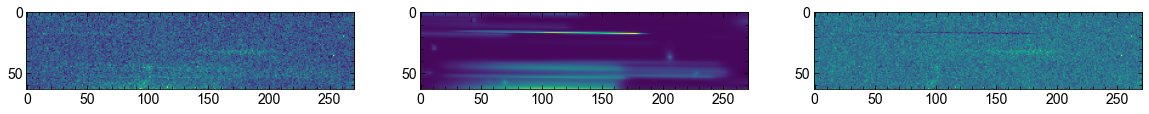

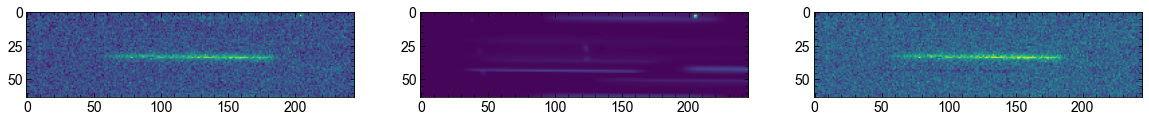

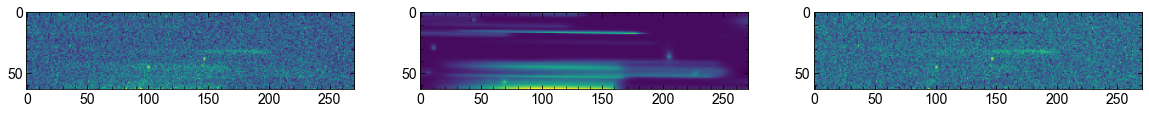

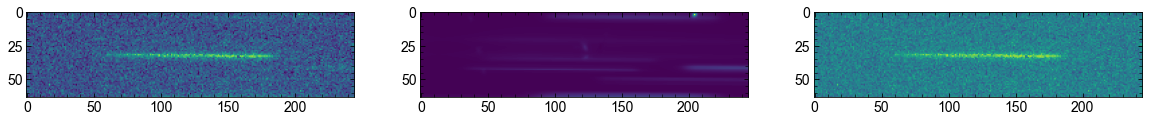

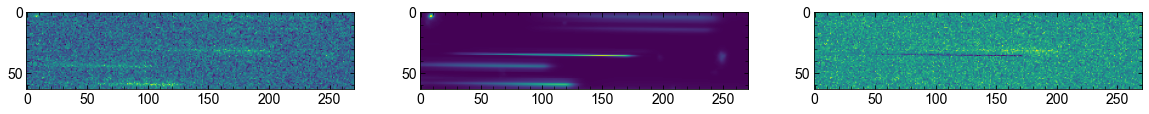

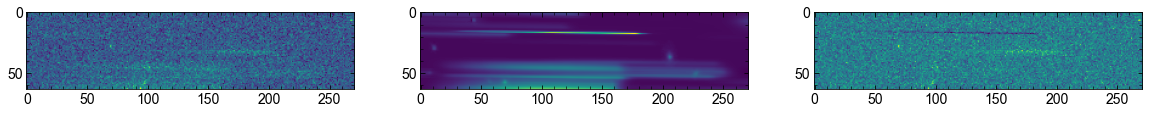

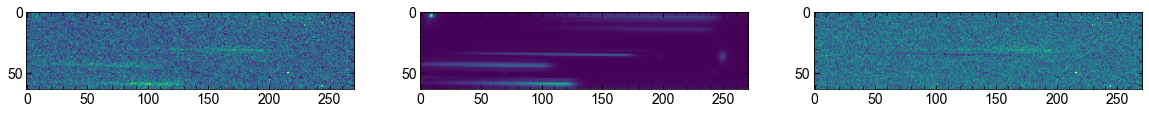

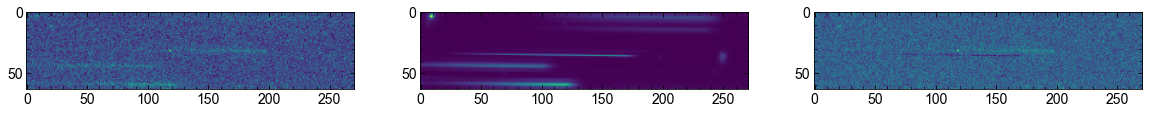

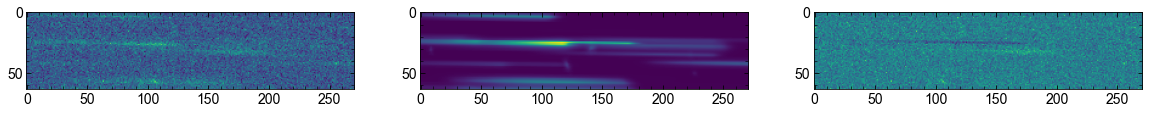

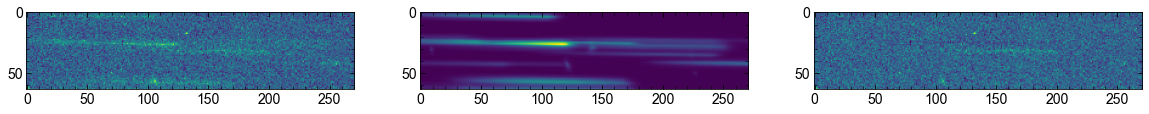

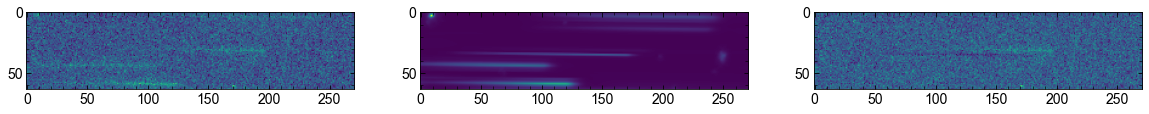

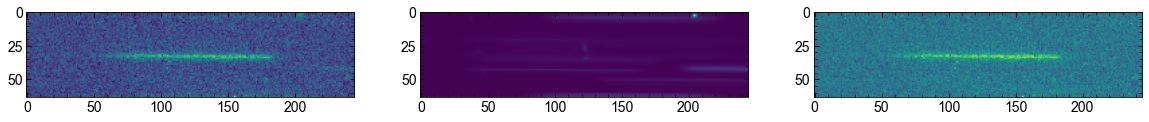

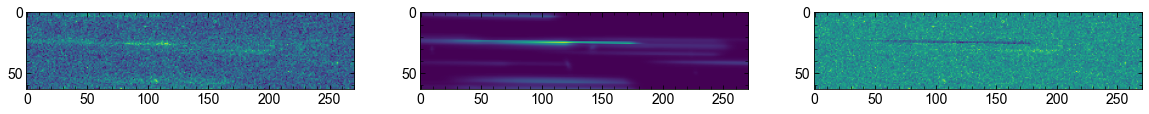

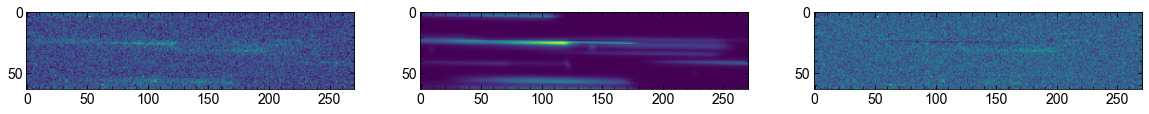

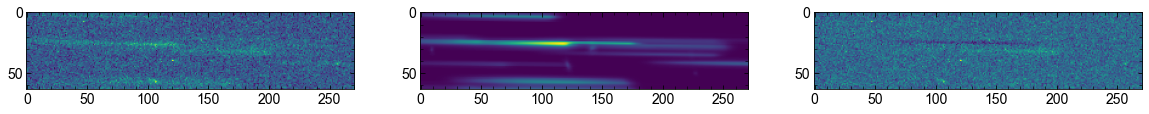

In [24]:
from matplotlib import gridspec
for beam in mb.beams:
    plt.figure(figsize = [20,5])
    gs = gridspec.GridSpec(1,3)
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])


    ax1.imshow(beam.grism.data['SCI'])
    ax2.imshow(beam.contam)
    ax3.imshow(beam.grism.data['SCI'] - beam.contam)

In [25]:
## Here we will do a template fit at z = 1.6148

temps = mb.template_at_z(1.6148, templates = args['t1'], fitter='lstsq')

In [26]:
## the template fits include a fit to the backgroud for every beam,
## stellar populations, and emission lines
temps

OrderedDict([('cont1d', <grizli.utils.SpectrumTemplate at 0x1adb1c1710>),
             ('line1d', <grizli.utils.SpectrumTemplate at 0x1a3caa4da0>),
             ('cfit',
              OrderedDict([('bg 000',
                            (-0.009826397297535663, 0.0008616144874877901)),
                           ('bg 001',
                            (-0.013597570339563846, 0.0007965788808047678)),
                           ('bg 002',
                            (-0.006223501805102401, 0.0007986492575578854)),
                           ('bg 003',
                            (-0.013452448790904147, 0.000786323216800454)),
                           ('bg 004',
                            (-0.008085586159179613, 0.0007208033457674356)),
                           ('bg 005',
                            (-0.006619621958881404, 0.0007227241277684084)),
                           ('bg 006',
                            (-0.00747561293496176, 0.0012241152194965418)),
                           

In [27]:
## here we can generate a table using our fits

sptbl = mb.oned_spectrum(tfit = temps)

In [28]:
sptbl['G102']

<GTable length=181>
       wave          flux    err    npix ...  contam   line    cont 
     Angstrom       ct / s  ct / s       ...  ct / s  ct / s  ct / s
     float64       float64 float64 int64 ... float64 float64 float64
------------------ ------- ------- ----- ... ------- ------- -------
 7709.083226562024     0.0     0.0     0 ...     0.0     0.0     0.0
 7727.271106774711     0.0     0.0     0 ...     0.0     0.0     0.0
 7745.501891710592     0.0     0.0     0 ...     0.0     0.0     0.0
 7763.775682580761     0.0     0.0     0 ...     0.0     0.0     0.0
 7782.092580835067     0.0     0.0     0 ...     0.0     0.0     0.0
 7800.452688162677     0.0     0.0     0 ...     0.0     0.0     0.0
  7818.85610649264     0.0     0.0     0 ...     0.0     0.0     0.0
 7837.302937994453     0.0     0.0     0 ...     0.0     0.0     0.0
7855.7932850786265     0.0     0.0     0 ...     0.0     0.0     0.0
               ...     ...     ...   ... ...     ...     ...     ...
   11534.605366254     0.0     0.0     0 ...     0.0     0.0     0.0
11561.817550923999     0.0     0.0     0 ...     0.0     0.0     0.0
11589.093928410153     0.0     0.0     0 ...     0.0     0.0     0.0
  11616.4346501416     0.0     0.0     0 ...     0.0     0.0     0.0
11643.839867904691     0.0     0.0     0 ...     0.0     0.0     0.0
11671.309733843846     0.0     0.0     0 ...     0.0     0.0     0.0
11698.844400462382     0.0     0.0     0 ...     0.0     0.0     0.0
11726.444020623365     0.0     0.0     0 ...     0.0     0.0     0.0
 11754.10874755047     0.0     0.0     0 ...     0.0     0.0     0.0
11781.838734828818     0.0     0.0     0 ...     0.0     0.0     0.0

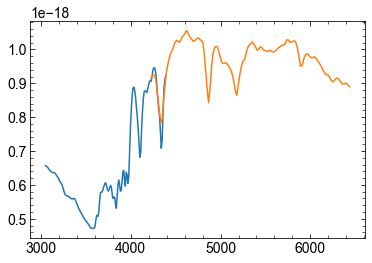

In [30]:
plt.plot(sptbl['G102']['wave'] / (1 + 1.6148), (sptbl['G102']['cont'])/sptbl['G102']['flat'])
plt.plot(sptbl['G141']['wave'] / (1 + 1.6148), (sptbl['G141']['cont'])/sptbl['G141']['flat'])